In [499]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import scipy.stats
from ultranest import ReactiveNestedSampler
from ultranest.plot import cornerplot
from scipy.special import lambertw
import os
from scipy.optimize import curve_fit
import scipy.stats
import numpy
import pdb
import warnings
warnings.filterwarnings("ignore")

Load in the data, get rid of NaNs and separate the data into a list according to separate bands

In [500]:
sn='2020itj'
lc_data = pd.read_csv('/Users/lalvopis/SNe_ICE/Photometry/geza_typeII/'+sn+'.csv', sep = ',')
cnd = np.isnan(lc_data['f'])

lc_data = lc_data[~cnd]

bands = ['c', 'o', 'ztfg', 'ztfr']
#bands = ['o', 'ztfg', 'ztfr']
lcs = []
for i in range (len(bands)):
    lcs.append(lc_data[lc_data['band'] == bands[i]])
    
#print(lcs)

Cut the relevant parts. Since the fitting function is simple, we can only use the initial rise, the first peak/plateu and the non-detections

In [501]:
cut_lcs = []

#2020nny
# c_lim = [58950, 59035]
# o_lim = [58950, 59040]
# g_lim = [58980, 59040]
# r_lim = [58980, 59038]

# # #2020jfo
# o_lim = [58965, 59000]
# g_lim = [58965, 58985]
# r_lim = [58965, 58985]

# #2020kjt
# o_lim = [58895, 59000]
# g_lim = [58895, 59000]
# r_lim = [58895, 59000]

# #2020kjt
# c_lim = [58950, 59035]
# o_lim = [58985, 59005]
# g_lim = [58985, 59005]
# r_lim = [58985, 59005]

#2020kjt
c_lim = [58940, 58985]
o_lim = [58940, 58985]
g_lim = [58940, 58985]
r_lim = [58940, 58985]

for i in range (len(lcs)):
    if lcs[i]['band'].values[0] == 'c':
        lim_cond = (lcs[i]['mjd'] > c_lim[0]) & (lcs[i]['mjd'] < c_lim[1])
    if lcs[i]['band'].values[0] == 'o':
        lim_cond = (lcs[i]['mjd'] > o_lim[0]) & (lcs[i]['mjd'] < o_lim[1])
    elif lcs[i]['band'].values[0] == 'ztfg':
        lim_cond = (lcs[i]['mjd'] > g_lim[0]) & (lcs[i]['mjd'] < g_lim[1])
    else:
        lim_cond = (lcs[i]['mjd'] > r_lim[0]) & (lcs[i]['mjd'] < r_lim[1])
        
    cut_lcs.append(lcs[i][lim_cond])

Separate actual detections and non-detections by putting in a limit. This is a very by-hand step; I just made this to follow the prescription of the past analysis

In [502]:
lcs_nd = []
photo_vls = []
for i in range (len(cut_lcs)):
    if len(cut_lcs[i]) > 0:
        cond = cut_lcs[i]['mjd'] < 58961 #kjt:58930 #jfo: 58972 #nny:59010
        lcs_nd.append(cut_lcs[i][cond].values[:,:3].astype(float))
        photo_vls.append(cut_lcs[i][~cond].values[:,:3].astype(float))
    else:
        lcs_nd.append([])
        photo_vls.append([])
        
print(photo_vls)
print(lcs_nd)

[array([[ 5.896250e+04, -5.500000e+01,  2.600000e+01],
       [ 5.896648e+04,  1.150000e+01,  5.120000e+00],
       [ 5.897163e+04, -2.900000e+01,  4.800000e+01],
       [ 5.898339e+04,  8.875000e+01,  5.120000e+00]]), array([[5.896440e+04, 1.650000e+01, 1.212000e+01],
       [5.896849e+04, 2.567000e+01, 5.770000e+00],
       [5.896945e+04, 3.017000e+01, 4.760000e+00],
       [5.897147e+04, 3.625000e+01, 7.250000e+00],
       [5.897237e+04, 2.850000e+01, 1.025000e+01],
       [5.897339e+04, 4.775000e+01, 9.620000e+00],
       [5.897747e+04, 1.245000e+02, 1.450000e+01],
       [5.897853e+04, 8.350000e+01, 2.875000e+01],
       [5.898042e+04, 1.040000e+02, 1.300000e+01],
       [5.898143e+04, 8.075000e+01, 7.250000e+00],
       [5.898245e+04, 8.950000e+01, 7.120000e+00],
       [5.898445e+04, 9.675000e+01, 5.620000e+00]]), array([[5.89633282e+04, 1.37856654e+01, 2.87901488e+00],
       [5.89633295e+04, 1.01308103e+01, 3.11655199e+00],
       [5.89633341e+04, 4.23990171e+00, 2.75252381e+0

In [503]:
# The initial t0 guess
t0_guess = 58957 #kjt:58930 #jfo: 58974 #nny: 59000 

# Normalize the flux values, subtract initial t0 guess from times.
for i in range (len(photo_vls)):
    if len(photo_vls[i]) > 0:
        norm_fact = max(photo_vls[i][:,1])
        lcs_nd[i][:,2] /= norm_fact
        lcs_nd[i][:,1] /= norm_fact
        lcs_nd[i][:,0] -= t0_guess
        
        photo_vls[i][:,2] /= norm_fact
        photo_vls[i][:,1] /= norm_fact
        photo_vls[i][:,0] -= t0_guess
        
print(lcs_nd)
print(photo_vls)

[array([[ 1.48      , -0.0056338 ,  0.04642254],
       [ 2.47      , -0.08642254,  0.06073239]]), array([[-1.44800000e+01,  6.42570281e-02,  9.83935743e-02],
       [-6.48000000e+00,  1.11244980e+00,  6.75903614e-01],
       [-5.57000000e+00, -6.82730924e-02,  6.82730924e-02],
       [-4.48000000e+00, -2.14457831e-02,  5.56626506e-02],
       [-3.52000000e+00, -4.21686747e-02,  4.91566265e-02],
       [-5.40000000e-01,  8.03212851e-03,  4.32931727e-02],
       [ 4.90000000e-01,  7.02811245e-02,  4.32128514e-02],
       [ 3.50000000e+00,  4.01606426e-03,  6.53012048e-02]]), array([[-1.66213079e+01, -1.99001404e-02,  5.43983839e-02],
       [-1.55209954e+01, -1.74881650e-02,  3.77026660e-02],
       [-1.35906713e+01, -5.30978780e-04,  6.48537318e-02],
       [-1.35791551e+01, -2.81222690e-02,  5.84828880e-02],
       [-2.62195600e+00, -3.50089852e-02,  4.35537966e-02],
       [-1.66736110e+00, -3.96103968e-03,  3.42014172e-02]]), array([[-16.5838773 ,   0.42654887,   0.2561044 ],
      

## Fitting procedure using Ultranest
For ultranest one has to set up the parameters and the priors in a reasonable range


In [504]:
parameters = ['t0', 'fmc', 'fmo', 'fmg', 'fmr', 'tec', 'teo', 'teg', 'ter' ,'f']
#parameters = ['t0', 'fmo', 'fmg', 'fmr', 'teo', 'teg', 'ter' ,'f']


def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    params[0] = cube[0] * 10 + 5      # parameter for t0; t0 guess has already been subtracted from the data
    params[1] = cube[1] * 0.6 + 0.4   # the plateou flux values; since the fluxes are normalized, this should be close to 1
    params[2] = cube[2] * 0.6 + 0.4
    params[3] = cube[3] * 0.6 + 0.4
    params[4] = cube[4] * 0.6 + 0.4
    params[5] = cube[5] * 5           # the charachteristic rise time; this should be on the order of days
    params[6] = cube[6] * 5
    params[7] = cube[7] * 5
    params[8] = cube[8] * 5
    params[9] = cube[9] * 3           # error inflation parameter; in case uncertainties are underestimated
    
#     params[0] = cube[0] * 10 + 5      # parameter for t0; t0 guess has already been subtracted from the data
#     params[1] = cube[1] * 0.6 + 0.4   # the plateou flux values; since the fluxes are normalized, this should be close to 1
#     params[2] = cube[2] * 0.6 + 0.4
#     params[3] = cube[3] * 0.6 + 0.4
#     params[4] = cube[4] * 5           # the charachteristic rise time; this should be on the order of days
#     params[5] = cube[5] * 5
#     params[6] = cube[6] * 5
#     params[7] = cube[7] * 3           # error inflation parameter; in case uncertainties are underestimated
    #pdb.set_trace()
    
    return params

In [508]:
# The fitting function; inverse exponential
def flux_evol(x, fm, t0, te):    
    return fm * (1 - np.exp(-(x - t0)/te))

def flux_evol_mod(x, fm, t0, te, offs):
    cond = x < t0
    result = np.zeros(x.shape)
    
    result[cond] = offs
    result[~cond] = fm * (1 - np.exp(-(x[~cond] - t0)/te)) + offs
    
    return result

Likelihood for the Bayesian fitting: this is where the different band light curves get connected through t0 and the rise time condition

In [509]:
def log_likelihood(params):
    
    t0, fmc, fmo, fmg, fmr, tec, teo, teg, ter, f = params
    #t0, fmo, fmg, fmr, teo, teg, ter, f = params
    fms = [fmc, fmo, fmg, fmr] #peak flux for each band
    #fms = [fmo, fmg, fmr] #peak flux for each band
    tes = [tec, teo, teg, ter] #rise-time for each band
    #tes = [teo, teg, ter] #rise-time for each band

    # Check for the models in each band if the model light curve goes ABOVE the non-detections
    #if yes, that is a bad model
    for i in range (len(photo_vls)):   # I have put in here the last g_nondet for simplicity
        try:
            # It is enough to check this for the last non-det, if it is deep enough
            non_dec_cond = lcs_nd[i][-1,1] < flux_evol(lcs_nd[i][-1,0], fm=fms[i], t0=t0, te=tes[i])  

            if non_dec_cond:
                return -9999
        # It can happen that we have no non-detections, then we cannot check the condition
        #this is here to catch that
        except (IndexError,AttributeError):  
            pass
        
    # check if te.c > te.o
    #the ATLAS C band light curve should rise faster than the O band (redder bands rise slower)
    if tes[0] > tes[1]:
        return -9999
    # same for ztf g and r
    if tes[2] > tes[3]:
    #if tes[1] > tes[2]:
        return -9999

    # if any of the above, return -9999, force the sampler away
    
    # if we are still in here, do the actual loglike calculation
    loglike = 0
    for i in range (len(photo_vls)):
        y_model = flux_evol(photo_vls[i][:,0], fm=fms[i], t0=t0, te=tes[i])
    
        sigma2 = photo_vls[i][:,2]**2 + y_model **2 * f**2    # the error inflation comes in here
        loglike += -0.5 * np.sum((y_model - photo_vls[i][:,1])**2 / sigma2 + np.log(2*np.pi*sigma2))

    return loglike

Do the fitting; this code can throw an AssertionError, if so, check if there are NaNs in the data. 

If no, just run the above def scripts again, and try once more; sometimes it starts from the wrong initial parameters

In [510]:
sampler = ReactiveNestedSampler(parameters, log_likelihood, prior_transform,
    wrapped_params=np.full(len(parameters), False)
)

#400 does the trick, but if you need sharp posteriors, might want to increase it; computationally expensive!
result = sampler.run(min_num_live_points=400, dKL=np.inf, min_ess=100) 

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=0.7   [-0.4772..-0.2939] | it/evals=1909/59731 eff=2.7085% N=98     8 N=98 
[ultranest] Likelihood function evaluations: 59976
[ultranest]   logZ = -12.99 +- 0.1772
[ultranest] Effective samples strategy satisfied (ESS = 608.1, need >100)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.48+-0.16 nat, need <inf nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.32 bs:0.18 tail:0.01 total:0.18 required:<0.50
[ultranest] done iterating.


Plot the results

2020itj best t0: 58962.84342603475
5.843426034746519


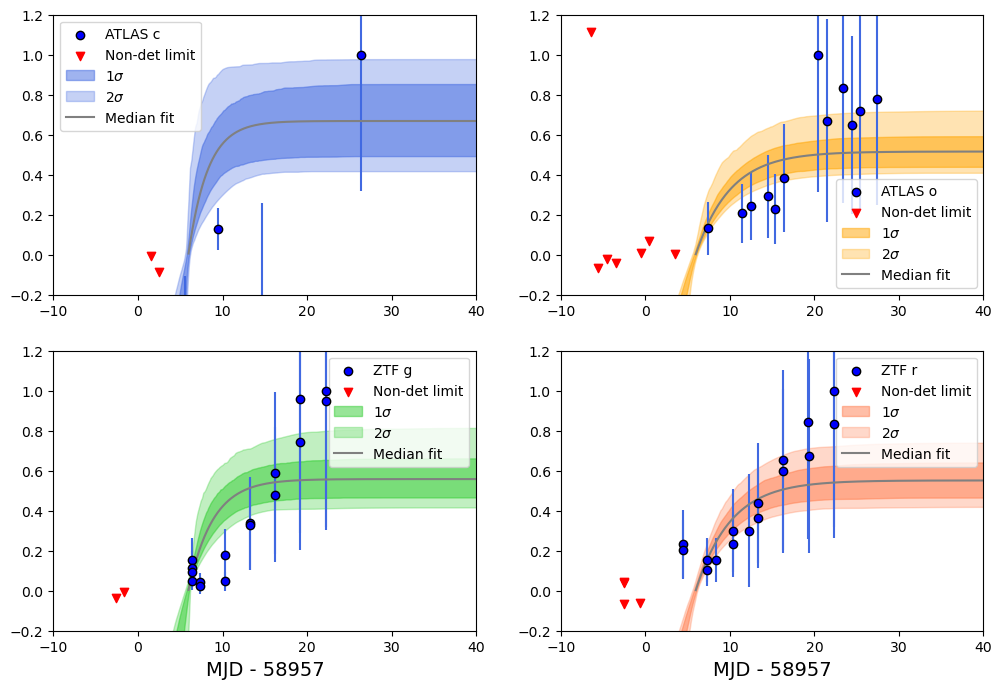

In [512]:
f = plt.figure(figsize = (12,8))
post_mean = sampler.results['posterior']['mean']

cls_s = ['blue', 'orange', 'green','red']
#cls_s = ['orange', 'green','red']

cls_line = ['royalblue', 'orange', 'limegreen','coral']
#cls_line = ['orange', 'limegreen','coral']

bands_labels = ['ATLAS c', 'ATLAS o', 'ZTF g', 'ZTF r']
#bands_labels = ['ATLAS o', 'ZTF g', 'ZTF r']
#pdb.set_trace()

for i in range (len(bands)):
    ax = f.add_subplot(2,2,i+1)
    
    if len(photo_vls[i]) > 0:
        plt.errorbar(photo_vls[i][:,0], photo_vls[i][:,1], np.sqrt(photo_vls[i][:,2]**2 + photo_vls[i][:,1]**2 * post_mean[-1]**2), fmt = '.', color = 'royalblue')
        plt.scatter(photo_vls[i][:,0], photo_vls[i][:,1], color = 'blue', edgecolor = 'black', zorder = 10,label=bands_labels[i])
        plt.scatter(lcs_nd[i][:,0], lcs_nd[i][:,1], color = 'red', marker = 'v',label='Non-det limit')
    
        t_grid = np.linspace(-10, 45, 700)
        #t_grid = np.linspace(-20, 50, 900)

        from ultranest.plot import PredictionBand
        band = PredictionBand(t_grid)

        # go through the solutions
        for t0, fmc, fmo, fmg, fmr, tec, teo, teg, ter, fadd in sampler.results['samples']:
        #for t0, fmo, fmg, fmr, teo, teg, ter, fadd in sampler.results['samples']:
            # compute for each time the y value
            fms = [fmc, fmo, fmg, fmr]
            tes = [tec, teo, teg, ter]
#             fms = [fmo, fmg, fmr]
#             tes = [teo, teg, ter]
            band.add(flux_evol(t_grid, fm=fms[i], t0=t0, te=tes[i]))

        y_mod = flux_evol(t_grid, fm=post_mean[1+i], t0=post_mean[0], te=post_mean[i+5])#te=post_mean[i+4])
        cond = y_mod > 0
        band.shade(color=cls_line[i], alpha=0.5, label = '1$\sigma$')
        band.shade(q=0.48, color=cls_line[i], alpha=0.3, label = '2$\sigma$')
        #pdb.set_trace()
        plt.plot(t_grid[cond], y_mod[cond], color = 'grey', lw = 1.5, label = 'Median fit')
        plt.legend()
        
        plt.ylim(-0.2, 1.2)
        
        plt.xlim(-10, 40)
        
        if i > 1:
            plt.xlabel('MJD - ' + str(np.round(t0_guess, 2)), fontsize = 14)
            
best_t0=t0_guess+t0
print(sn+' best t0: '+str(best_t0))
print(t0)

#plt.savefig('/Users/lalvopis/SNe_ICE/Photometry/geza_typeII/plots/'+sn+'_sep.png', format='png', dpi=300, bbox_inches = "tight")

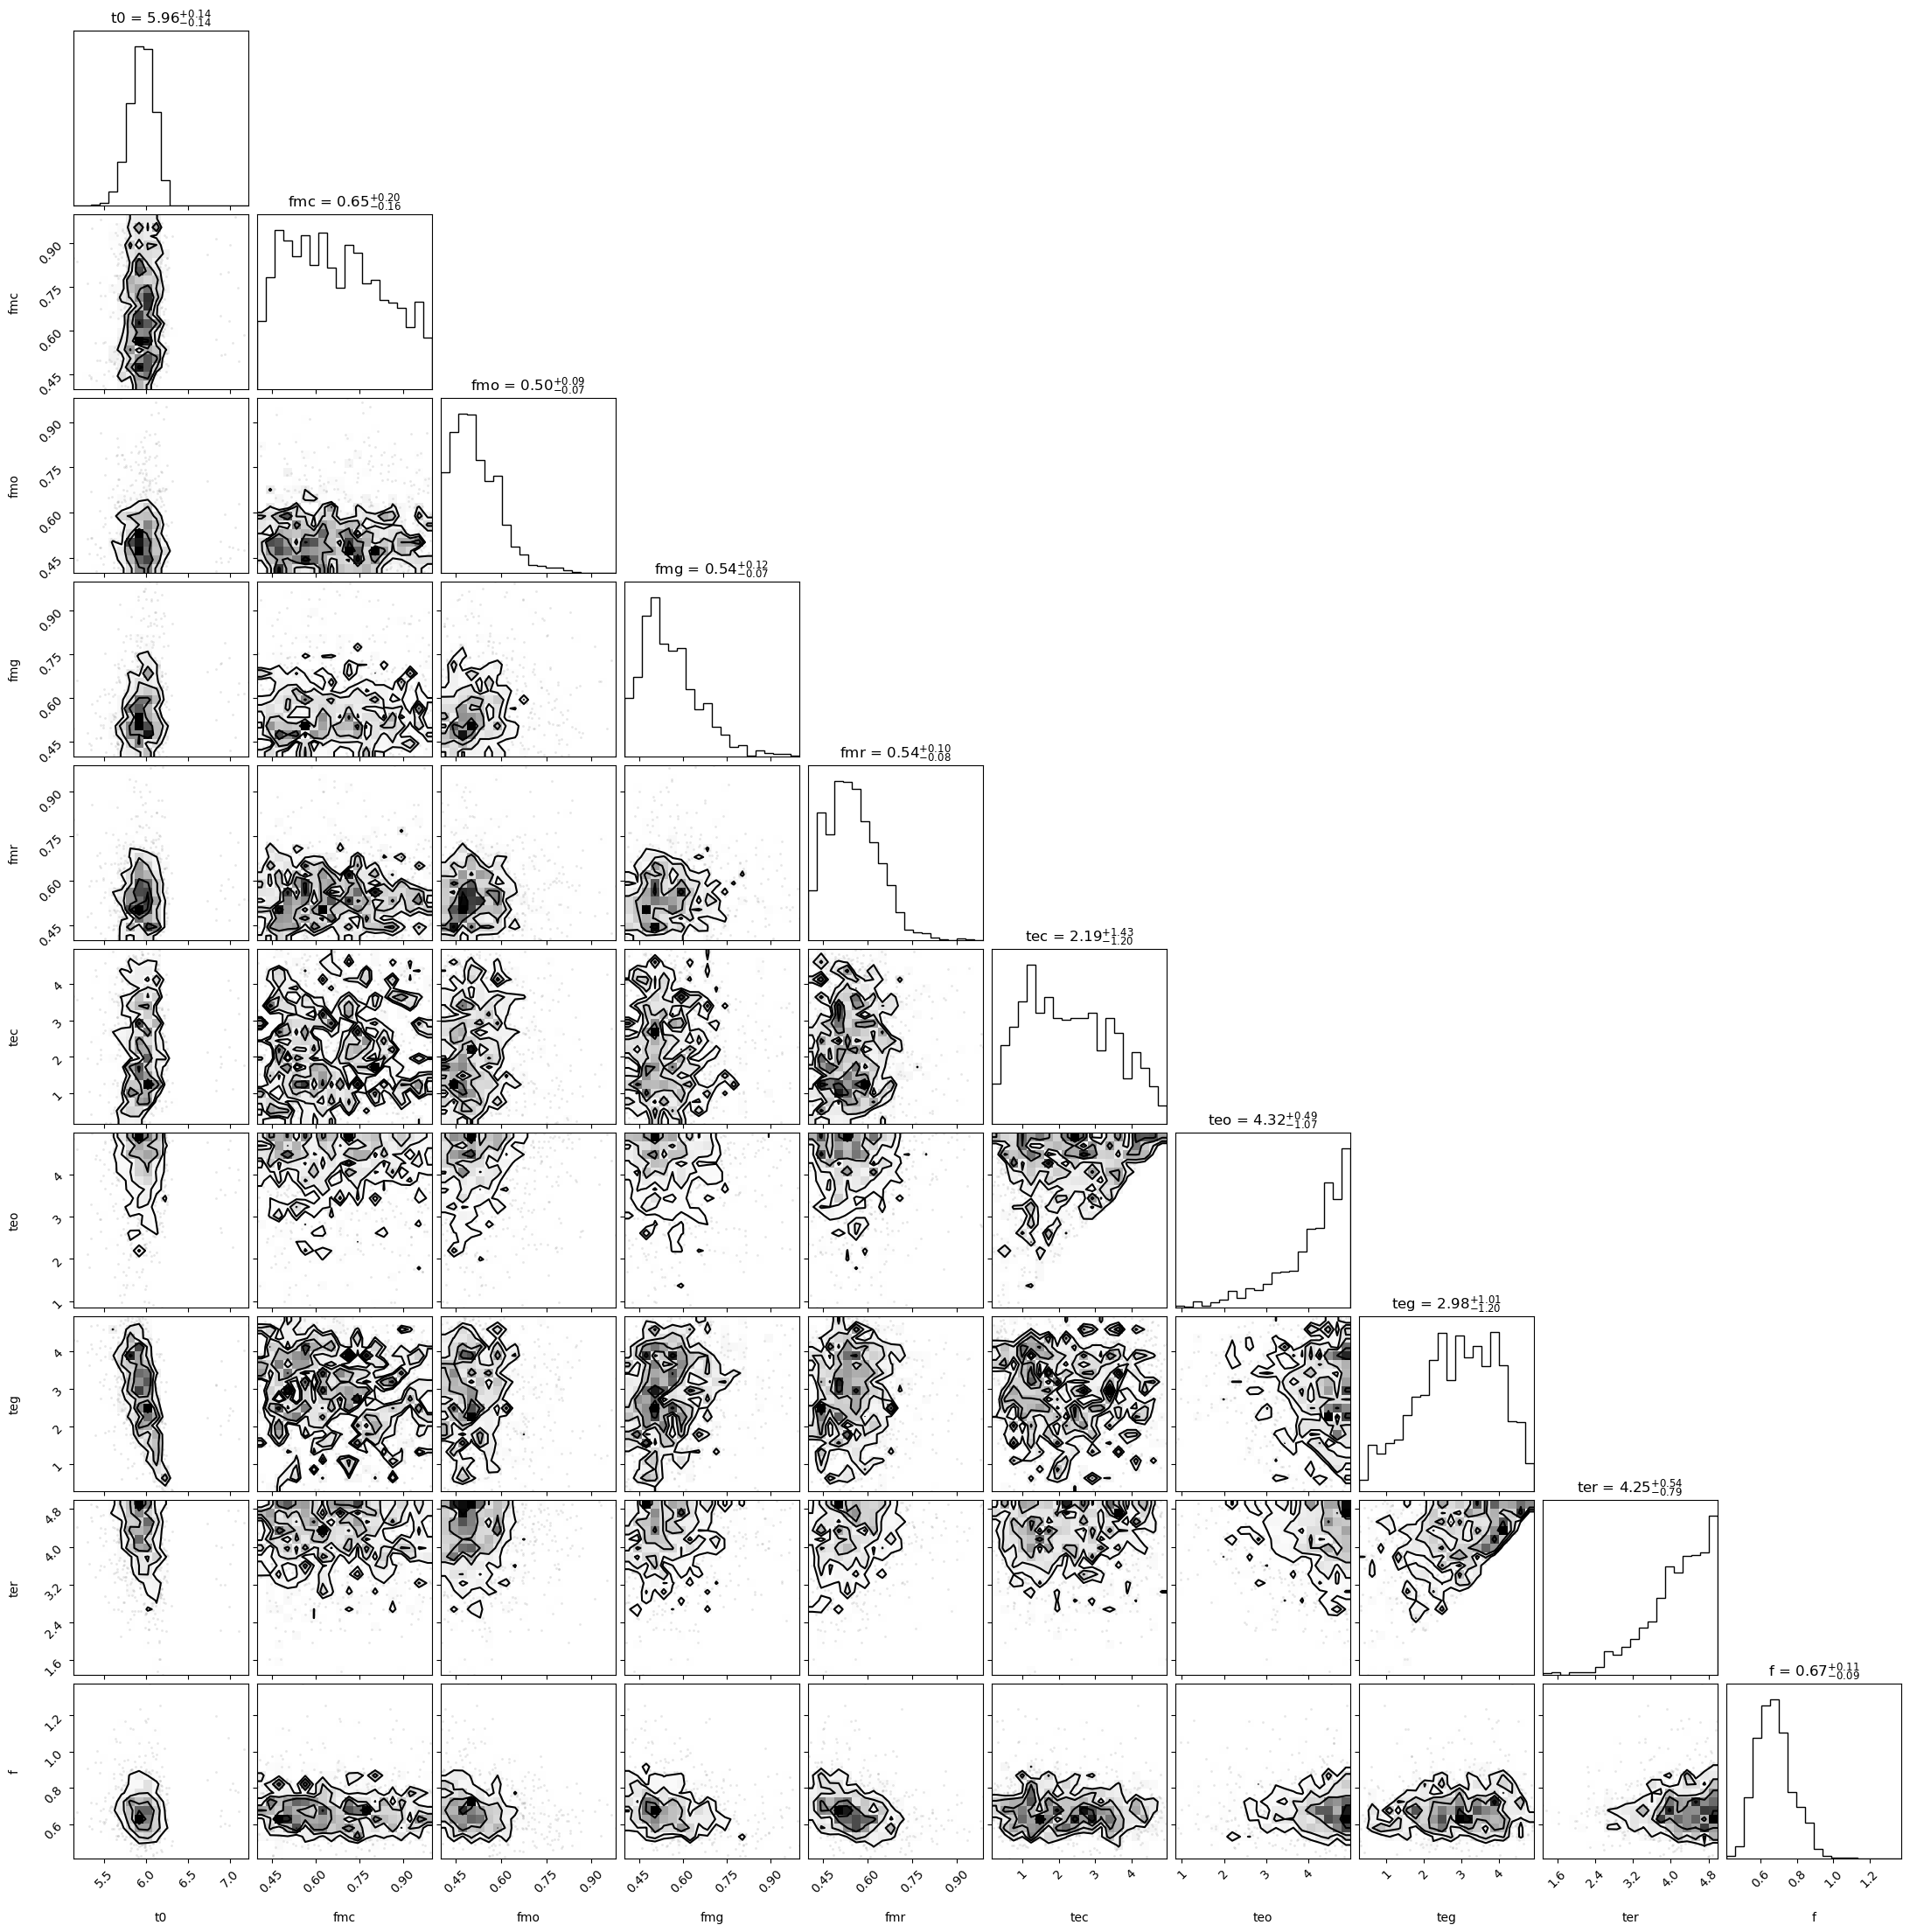

In [513]:
cornerplot(result)

Text(0.5, 1.0, 'SN 2020jfo')

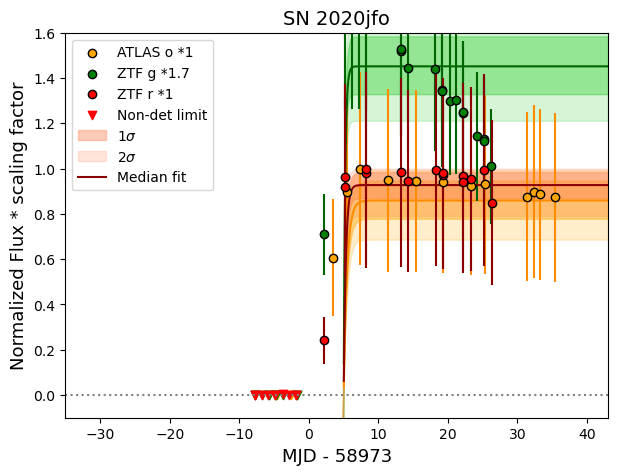

In [183]:
fig,ax = plt.subplots(1,1,figsize = (7,5))

#cls_s = ['blue', 'orange', 'green','red']
cls_s = ['orange', 'green','red']

#cls_line2 = ['darkblue', 'darkorange', 'darkgreen','darkred']
cls_line2 = ['darkorange', 'darkgreen','darkred']

#scale = [1.2, 2.6, 0.6, 1.7]
scale = [1,1.7,1]

for i in range (len(bands)):
    #ax = f.add_subplot(2,2,i+1)
    
    if len(photo_vls[i]) > 0:
        plt.errorbar(photo_vls[i][:,0], photo_vls[i][:,1]*scale[i], np.sqrt(photo_vls[i][:,2]**2 + photo_vls[i][:,1]**2 * post_mean[-1]**2), fmt = '.', color = cls_line2[i])
        plt.scatter(photo_vls[i][:,0], photo_vls[i][:,1]*scale[i], color = cls_s[i], edgecolor = 'k', zorder = 10,label=bands_labels[i]+' *'+str(scale[i]))
        plt.scatter(lcs_nd[i][:,0], lcs_nd[i][:,1], color = cls_s[i], marker = 'v',label='Non-det limit')
    
        t_grid = np.linspace(-10, 45, 700)

        from ultranest.plot import PredictionBand
        band = PredictionBand(t_grid)

        # go through the solutions
        #for t0, fmc, fmo, fmg, fmr, tec, teo, teg, ter, fadd in sampler.results['samples']:
        for t0, fmo, fmg, fmr, teo, teg, ter, fadd in sampler.results['samples']:
            # compute for each time the y value
#             fms = [fmc, fmo, fmg, fmr]
#             tes = [tec, teo, teg, ter]
            fms = [fmo, fmg, fmr]
            tes = [teo, teg, ter]
            band.add(flux_evol(t_grid, fm=fms[i], t0=t0, te=tes[i])*scale[i])

        y_mod = flux_evol(t_grid, fm=post_mean[1+i], t0=post_mean[0], te=post_mean[i+4])#te=post_mean[i+5])
        cond = y_mod > 0
        band.shade(color=cls_line[i], alpha=0.4, label = '1$\sigma$')
        band.shade(q=0.48, color=cls_line[i], alpha=0.2, label = '2$\sigma$')
        #pdb.set_trace()
        plt.plot(t_grid[cond], y_mod[cond]*scale[i], color =cls_line2[i], lw = 1.5, label = 'Median fit')
        
        plt.ylim(-0.1, 1.6)
        
        plt.xlim(-35, 43)
        
        if i > 1:
            plt.xlabel('MJD - ' + str(np.round(t0_guess, 2)), fontsize = 13)
            
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
#pdb.set_trace()
#order = [0,5,10,15,16,17,18,19]
order = [0,5,10,11,12,13,14]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10)#,bbox_to_anchor=(1.1, 0.4))#loc='upper right') 

plt.ylabel('Normalized Flux * scaling factor',fontsize=13)
plt.axhline(y=0,linestyle=':',color='gray')
plt.title('SN '+sn,fontsize=14)

# plt.savefig('/Users/lalvopis/SNe_ICE/Photometry/geza_typeII/plots/'+sn+'.png', format='png', dpi=300, bbox_inches = "tight")
# plt.savefig('/Users/lalvopis/SNe_ICE/Photometry/geza_typeII/plots/'+sn+'.pdf', format='pdf', dpi=300, bbox_inches = "tight")